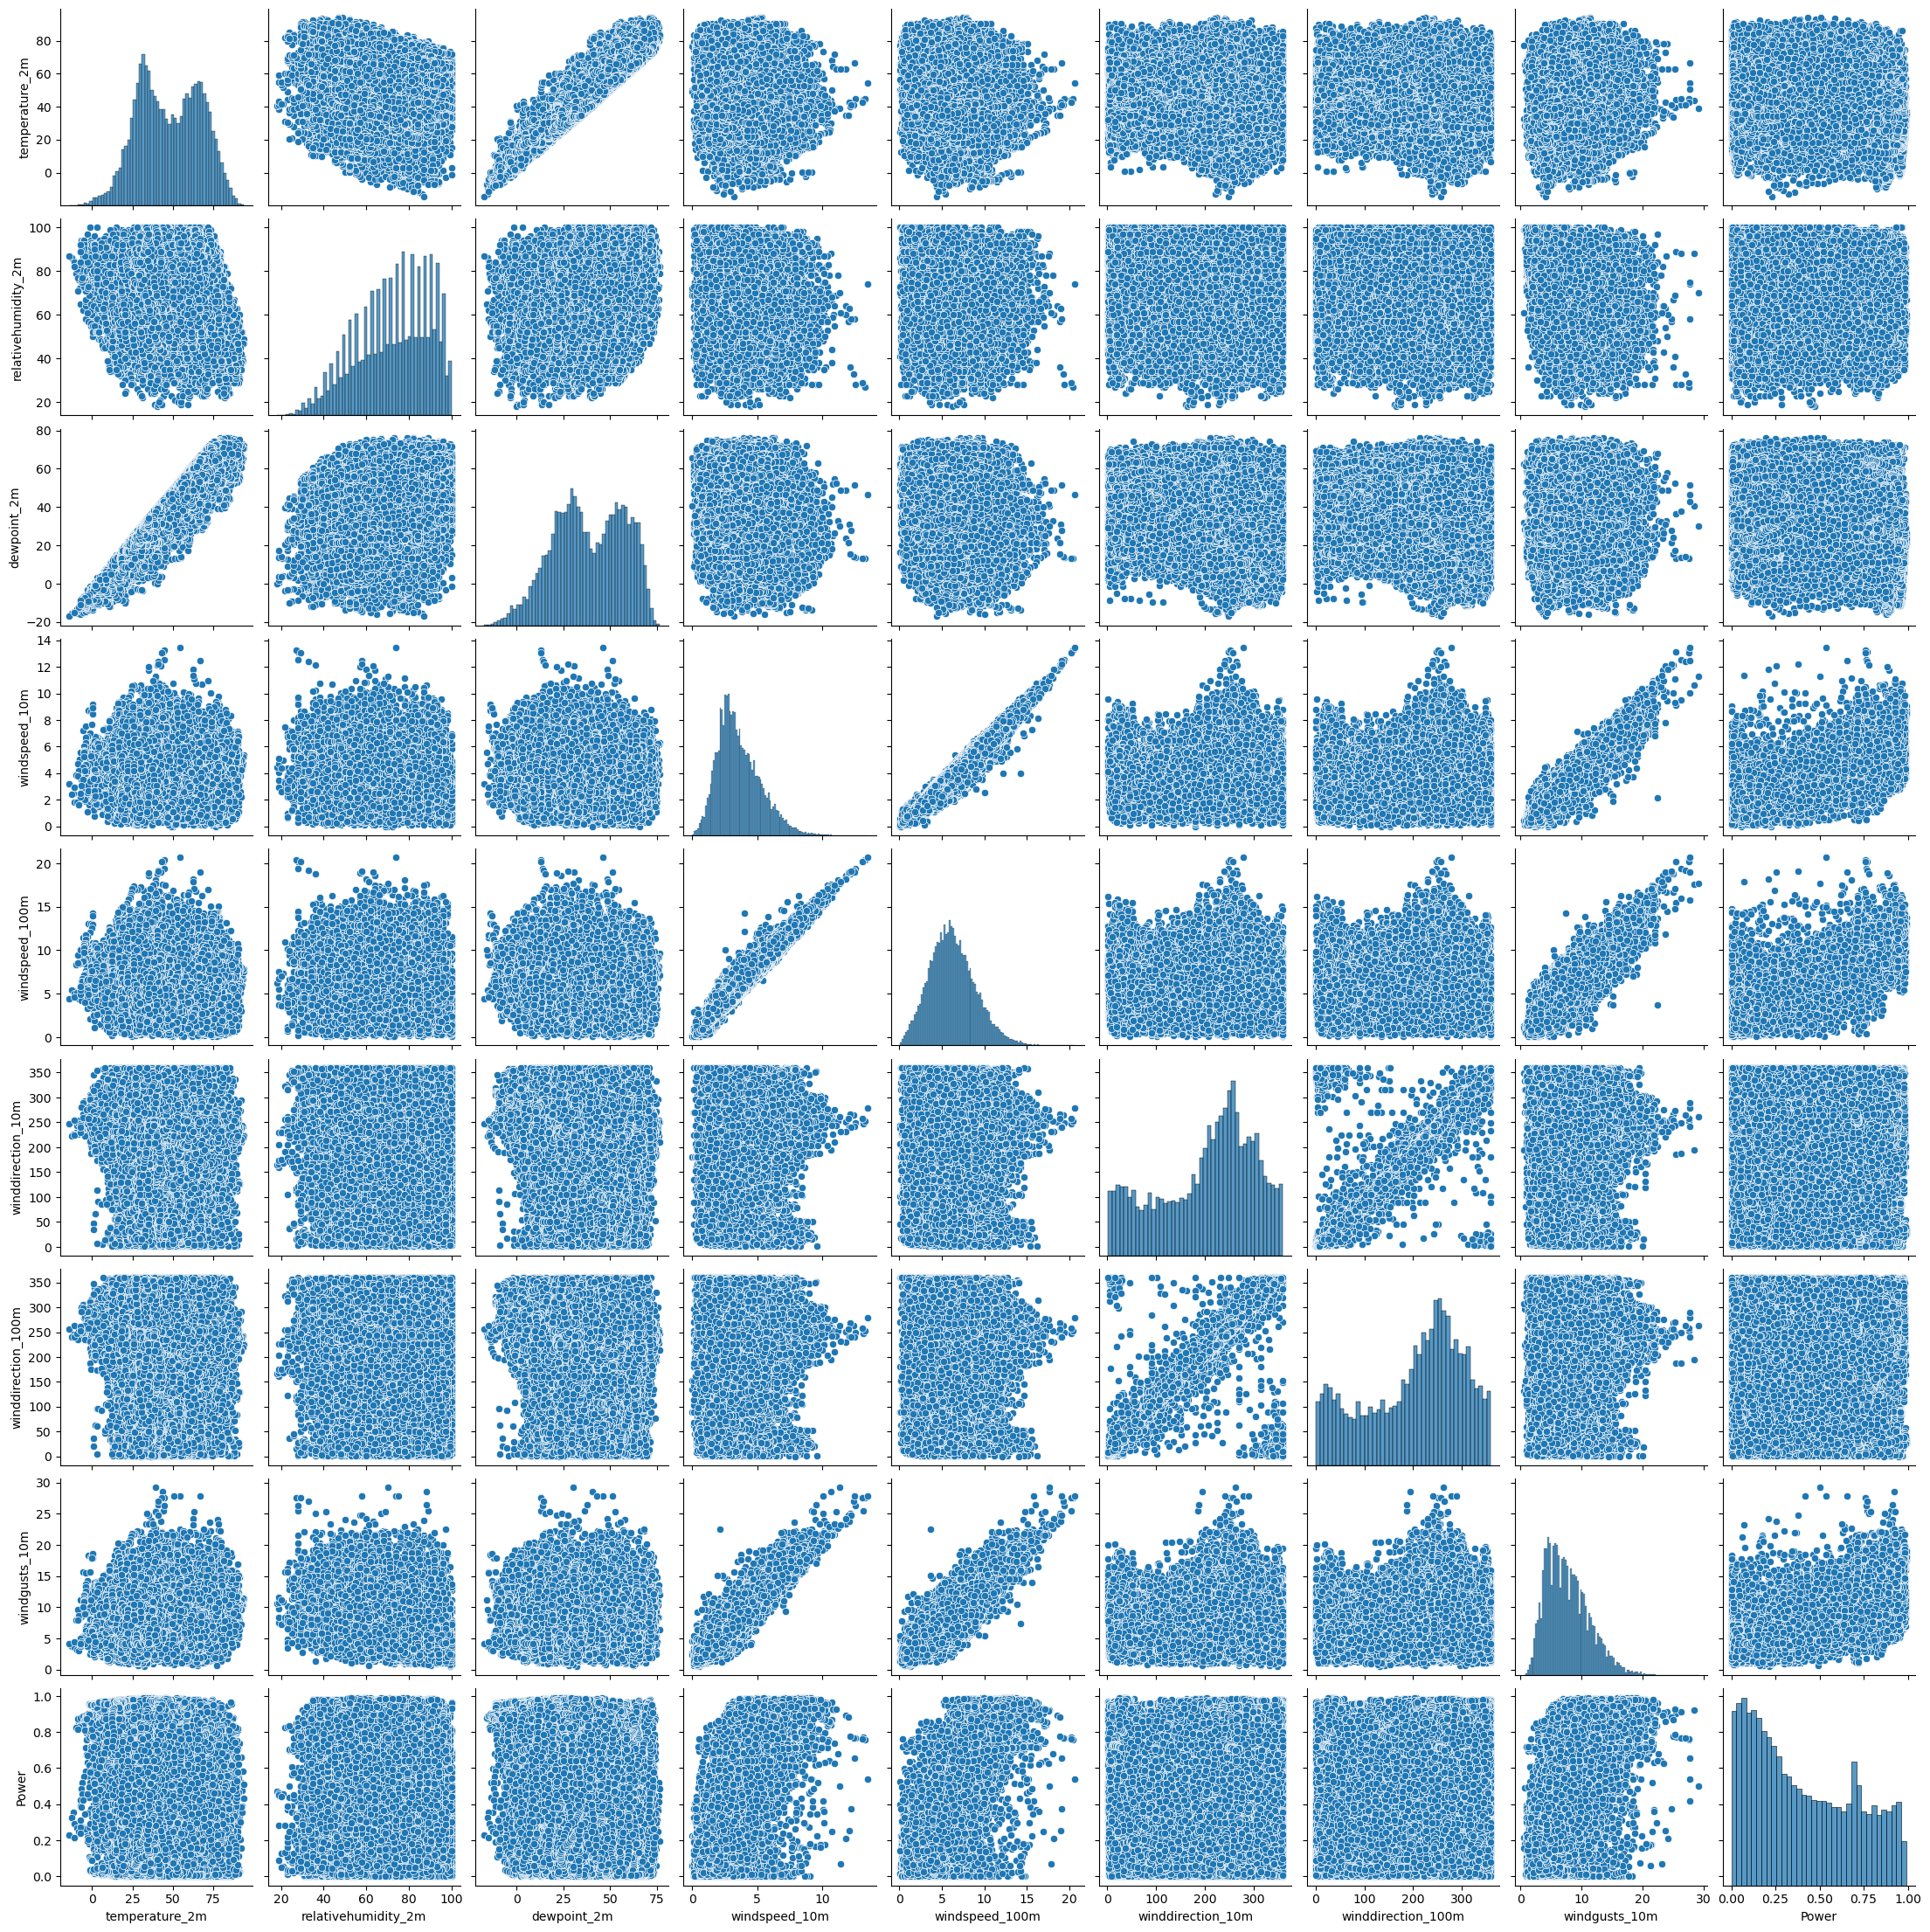

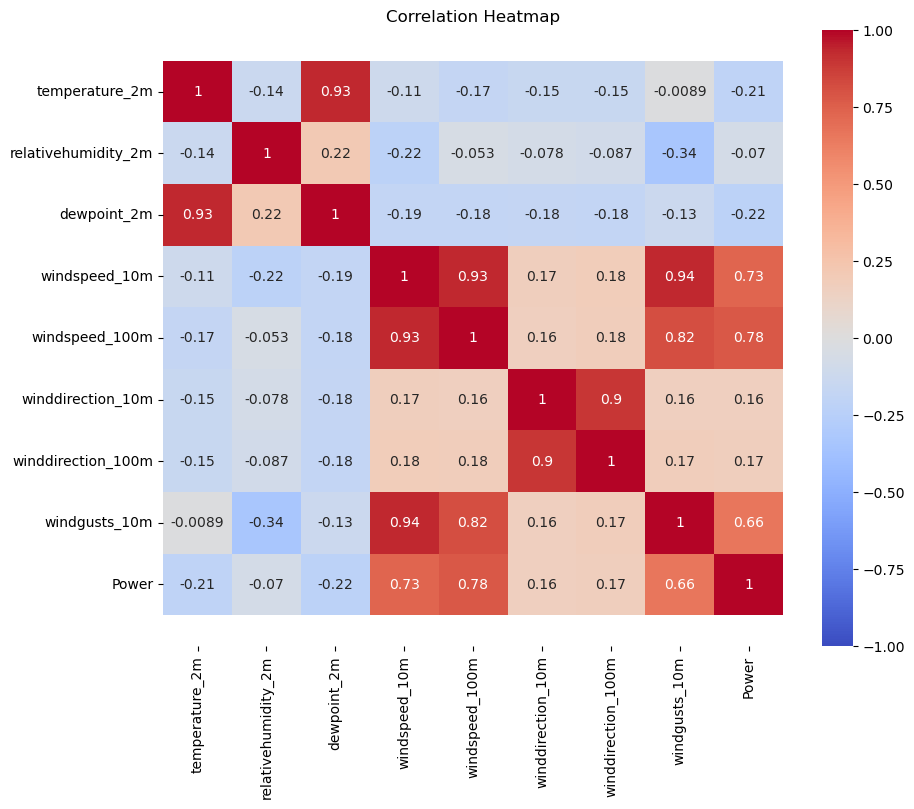

Correlation Matrix:

                     temperature_2m  relativehumidity_2m  dewpoint_2m  \
temperature_2m             1.000000            -0.137993     0.934813   
relativehumidity_2m       -0.137993             1.000000     0.217657   
dewpoint_2m                0.934813             0.217657     1.000000   
windspeed_10m             -0.112036            -0.221810    -0.185900   
windspeed_100m            -0.172390            -0.052752    -0.183938   
winddirection_10m         -0.151642            -0.078012    -0.176322   
winddirection_100m        -0.152324            -0.086712    -0.179764   
windgusts_10m             -0.008929            -0.342357    -0.127375   
Power                     -0.207101            -0.070360    -0.223739   

                     windspeed_10m  windspeed_100m  winddirection_10m  \
temperature_2m           -0.112036       -0.172390          -0.151642   
relativehumidity_2m      -0.221810       -0.052752          -0.078012   
dewpoint_2m              -0.1

In [12]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


#  Load dataset
df = pd.read_csv("/Users/ngchawanda/Documents/WindEnergyPrediction/data/dataset1.csv")

#Convert Time column to datetime
df["Time"] = pd.to_datetime(df["Time"])

# drop time for correlation
df_numeric = df.drop(columns=["Time"])

# plotting pair plot
sns.pairplot(df_numeric)
plt.show()

#plotting correlation heatmap
plt.figure(figsize=(10,8))

corr = df_numeric.corr()

ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm"
)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Correlation Heatmap")
plt.show()

# print correlation values
print("Correlation Matrix:\n")
print(corr)

# removing wind direction (low correlation)
df.drop(["winddirection_10m", "winddirection_100m","windspeed_100m",
    "winddirection_10m",
    "winddirection_100m",
    "windgusts_10m"], axis=1, inplace=True)

# convert time column
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

print(df.head())


# SPLITTING INTO X (independent) and y (dependent)


from sklearn.model_selection import train_test_split

# X = independent variables (all features except target)
X = df.drop(columns=[
    "Power",
    "Time"]) # drop target and time

# y = dependent variable (target)
y = df["Power"]

# split into train & test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)











In [14]:
#3.Model building 

#3.1 Choose the appropriate model

# MODEL BUILDING - RANDOM FOREST


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# create model
forest_model = RandomForestRegressor(
    n_estimators=750,
    max_depth=4,
    max_leaf_nodes=500,
    random_state=1
)

# train model
forest_model.fit(X_train, y_train)



RandomForestRegressor(max_depth=4, max_leaf_nodes=500, n_estimators=750,
                      random_state=1)

In [15]:
#3.2: Check the metrics of the model

from sklearn.metrics import mean_absolute_error, r2_score

# predict on test data
power_preds = forest_model.predict(X_test)

# evaluate model
print("MAE:", mean_absolute_error(y_test, power_preds))
print("R2 Score:", r2_score(y_test, power_preds))

MAE: 0.14440293440923443
R2 Score: 0.5877665332581629


In [16]:
#3.3: saving the model for future reference 

joblib.dump(forest_model, "power_prediction.sav")

['power_prediction.sav']

In [17]:
import pickle
pickle.dump(forest_model, open("wind_model.pkl","wb"))


In [19]:
import requests

API_KEY = "a6889edb39de1df32e6633dcef24c7d9"
city = "London"

url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"

response = requests.get(url)
data = response.json()


In [20]:
temp = data['main']['temp']
pressure = data['main']['pressure']
humidity = data['main']['humidity']
wind_speed = data['wind']['speed']

features = [[temp, pressure, humidity, wind_speed]]


In [21]:
prediction =forest_model.predict(features)

print("Predicted Energy Output:", prediction[0])


Predicted Energy Output: 0.8058784388446921


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [24]:
import numpy as np
from flask import Flask, request, jsonify, render_template
import joblib
import requests

In [25]:
app=Flask(__name__)
model=joblib.load('power_prediction.sav')